In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc, classification_report, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [2]:
# Read csv data file
df = pd.read_csv("../data/internet_service_churn.csv")

# drop user id
df.drop('id', axis=1, inplace=True)

print(df.shape)

# Data preview
print("\nThe first 5 rows of data:")
print(df.head())

(72274, 10)

The first 5 rows of data:
   is_tv_subscriber  is_movie_package_subscriber  subscription_age  bill_avg  \
0                 1                            0             11.95        25   
1                 0                            0              8.22         0   
2                 1                            0              8.91        16   
3                 0                            0              6.87        21   
4                 0                            0              6.39         0   

   reamining_contract  service_failure_count  download_avg  upload_avg  \
0                0.14                      0           8.4         2.3   
1                 NaN                      0           0.0         0.0   
2                0.00                      0          13.7         0.9   
3                 NaN                      1           0.0         0.0   
4                 NaN                      0           0.0         0.0   

   download_over_limit  churn  
0  

In [3]:
# Check if there are any rows with zeros
has_zero_rows = (df == 0).all(axis=1).any()
print("Are there any rows in the data that consist entirely of zeros?:", has_zero_rows)


Are there any rows in the data that consist entirely of zeros?: False


In [4]:
# Check if there are any variables with missing values
missing_values = df.isna().sum()
print("Number of missing values in each column:")
print(missing_values)

Number of missing values in each column:
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
reamining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64


> # Filling in missing values

In [5]:
# NaN in 'reamining_contract' means no contract, so fill with 0
df.fillna({'reamining_contract': 0}, inplace=True)
   
# NaN in the 'download_avg' and 'upload_avg' columns indicates inactivity, so fill with 0
df.fillna({'download_avg': 0}, inplace=True)
df.fillna({'upload_avg': 0}, inplace=True)

# Check if there are still NaNs in the columns
print(df.isna().sum())

is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
reamining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64


> # Data Exploration

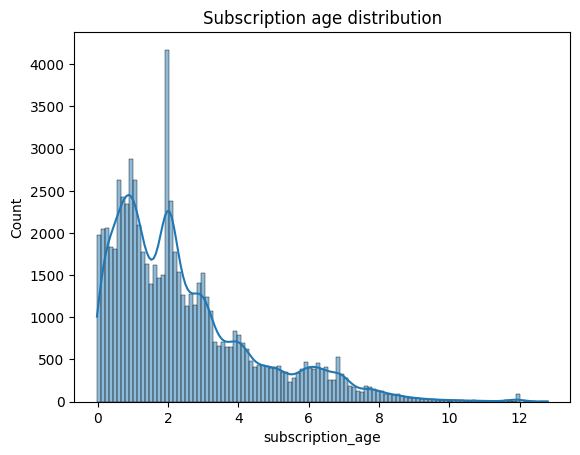

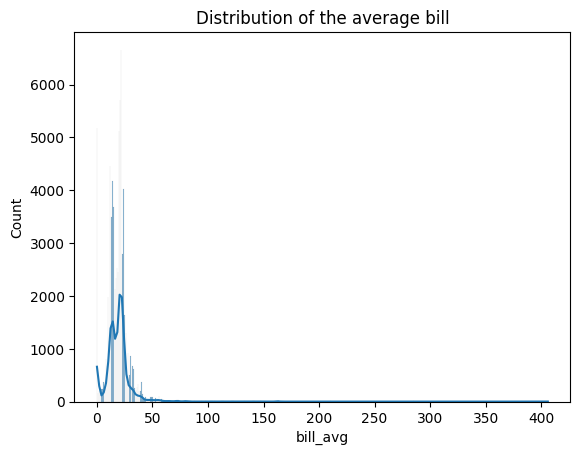

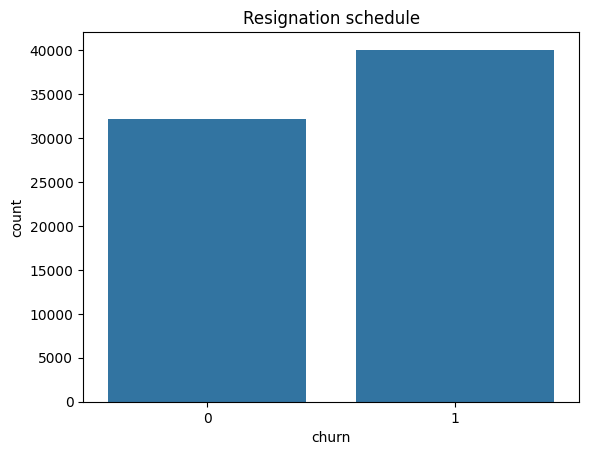

In [6]:
# Distribution of the 'subscription_age' variable_age'
sns.histplot(df['subscription_age'], kde=True)
plt.title('Subscription age distribution')
plt.show()

# Distribution of the 'bill_avg' variable
sns.histplot(df['bill_avg'], kde=True)
plt.title('Distribution of the average bill')
plt.show()

# Distribution of the 'churn' variable
sns.countplot(x='churn', data=df)
plt.title('Resignation schedule')
plt.show()

# Data standarization

In [7]:
# Selection of features for normalization
features_to_scale = ['subscription_age', 'bill_avg', 'reamining_contract', 'service_failure_count', 'download_avg', 'upload_avg']

# Feature normalization
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])
print(df.head())

   is_tv_subscriber  is_movie_package_subscriber  subscription_age  bill_avg  \
0                 1                            0          4.668335  0.458372   
1                 0                            0          2.835389 -1.433376   
2                 1                            0          3.174460 -0.222657   
3                 0                            0          2.171991  0.155692   
4                 0                            0          1.936116 -1.433376   

   reamining_contract  service_failure_count  download_avg  upload_avg  \
0           -0.541163              -0.335818     -0.553713   -0.190860   
1           -0.750269              -0.335818     -0.686378   -0.425611   
2           -0.750269              -0.335818     -0.470008   -0.333752   
3           -0.750269               0.888749     -0.686378   -0.425611   
4           -0.750269              -0.335818     -0.686378   -0.425611   

   download_over_limit  churn  
0                    0      0  
1         

# Correlation matrix

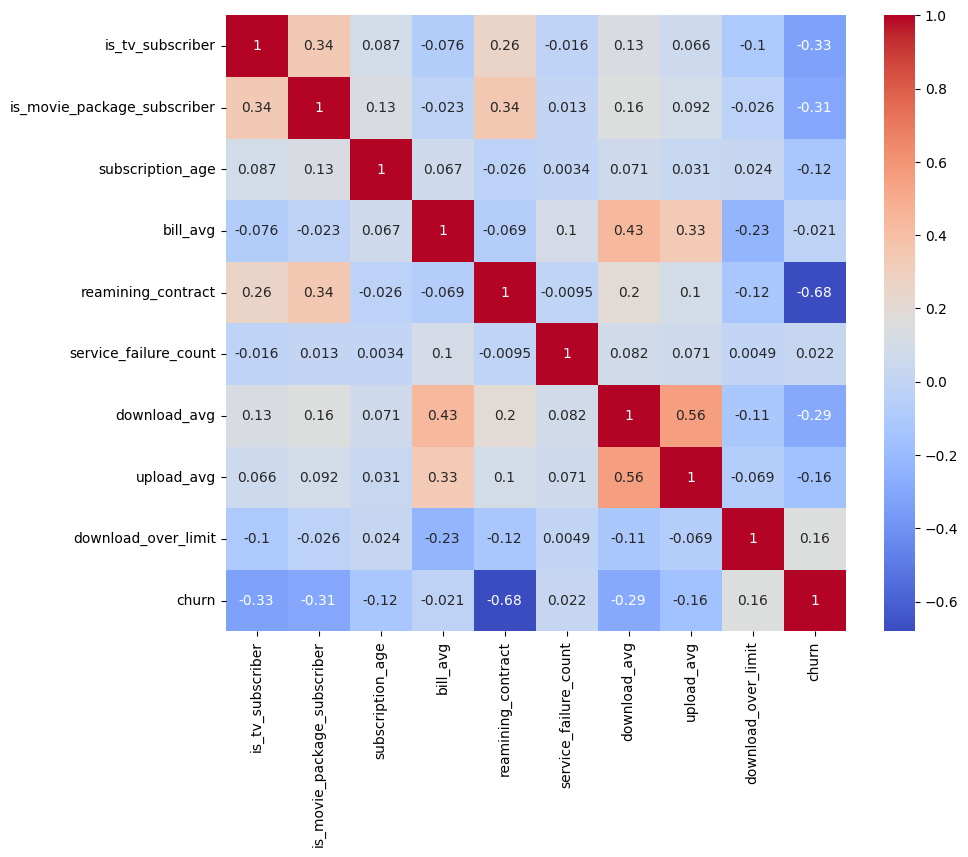

In [8]:
corr = df.corr()

# Visualization of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

# Division into training and test sets

In [9]:
# Splitting data into features (X) and target variable (y)
X = df.drop(columns=['churn'])
y = df['churn']

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

# Supervised Machine Learning Models

In [11]:
# Support Vector Machine (SVM) Model with SVC implementation with rbf kernel
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Logistic Regression Model (simpler model for comparison)
lr_model = LogisticRegression(random_state=42)

# Define the Gradient Boosting model
model_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

## Training models with cross validation

In [12]:
# Perform Cross-Validation and print results
def perform_cross_validation(model, X, y, cv=5):
    print(f"Performing cross-validation for {model.__class__.__name__}...")
    # Cross-validation for accuracy
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    
    print(f"Cross-Validation Results for {model.__class__.__name__}:")
    print(f"Accuracy: {np.mean(accuracy):.2f} (+/- {np.std(accuracy):.2f})")
    print("-" * 50)

In [13]:
# Perform Cross-Validation and print results
perform_cross_validation(svm_model, X_train, y_train)

# Train the SVM model with SVC implementation with rbf kernel
svm_model.fit(X_train, y_train)

Performing cross-validation for SVC...
Cross-Validation Results for SVC:
Accuracy: 0.91 (+/- 0.00)
--------------------------------------------------


SVC(probability=True, random_state=42)

In [14]:
# Perform Cross-Validation and print results
perform_cross_validation(rf_model, X_train, y_train)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

Performing cross-validation for RandomForestClassifier...
Cross-Validation Results for RandomForestClassifier:
Accuracy: 0.94 (+/- 0.00)
--------------------------------------------------


RandomForestClassifier(random_state=42)

In [15]:
# Perform Cross-Validation and print results
perform_cross_validation(lr_model, X_train, y_train)

# Train the Logistic Regression model
lr_model.fit(X_train, y_train)

Performing cross-validation for LogisticRegression...
Cross-Validation Results for LogisticRegression:
Accuracy: 0.87 (+/- 0.00)
--------------------------------------------------


LogisticRegression(random_state=42)

In [16]:
# Perform Cross-Validation and print results
perform_cross_validation(model_GB, X_train, y_train)

# Train the Gradient Boosting Classifier
model_GB.fit(X_train, y_train)

Performing cross-validation for GradientBoostingClassifier...
Cross-Validation Results for GradientBoostingClassifier:
Accuracy: 0.94 (+/- 0.00)
--------------------------------------------------


GradientBoostingClassifier(random_state=42)

## Model evaluation

In [17]:
def evaluate_model(model, X_test, y_test):
    model_name = model.__class__.__name__
    y_pred = model.predict(X_test)
    print(f"Evaluating {model_name}...")
    # Calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Displaying the results
    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy * 100:.1f}%")
    print(f"Recall: {recall * 100:.1f}%")
    print(f"Precision: {precision * 100:.1f}%")
    print(f"F1 Score: {f1 * 100:.1f}%")

    # Print full classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Evaluate SVM Model

Evaluating SVC...
SVC Results:
Accuracy: 90.8%
Recall: 92.7%
Precision: 90.9%
F1 Score: 91.8%

Classification Report:
              precision    recall  f1-score   support

           0      0.906     0.884     0.895      6422
           1      0.909     0.927     0.918      8033

    accuracy                          0.908     14455
   macro avg      0.907     0.905     0.906     14455
weighted avg      0.908     0.908     0.908     14455



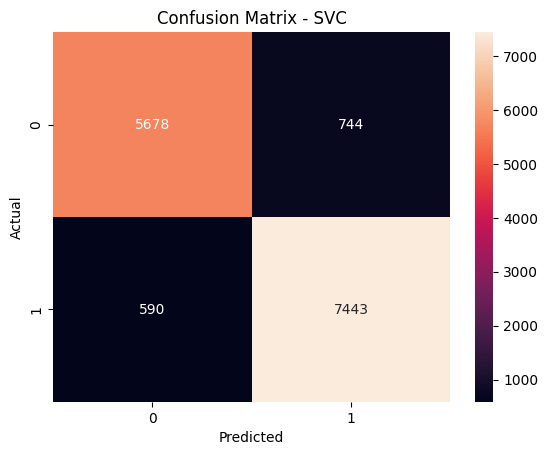

In [18]:
evaluate_model(svm_model, X_test, y_test)

In [19]:
# Save the model to a file using joblib
joblib.dump(svm_model, '../models/support_vector_classifier.pkl')

['../models/support_vector_classifier.pkl']

### Evaluate Random Forest Model

Evaluating RandomForestClassifier...
RandomForestClassifier Results:
Accuracy: 94.1%
Recall: 93.6%
Precision: 95.7%
F1 Score: 94.6%

Classification Report:
              precision    recall  f1-score   support

           0      0.922     0.948     0.935      6422
           1      0.957     0.936     0.946      8033

    accuracy                          0.941     14455
   macro avg      0.939     0.942     0.940     14455
weighted avg      0.941     0.941     0.941     14455



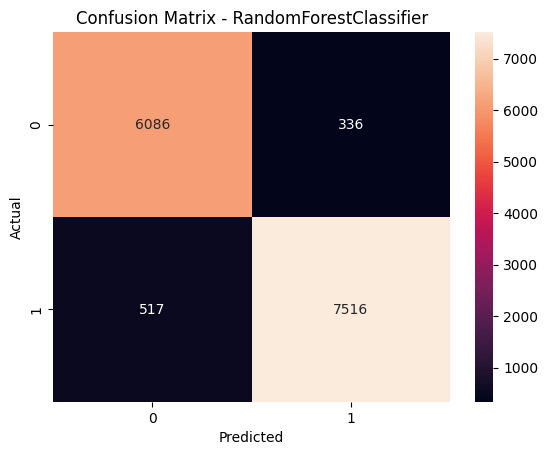

In [20]:
evaluate_model(rf_model, X_test, y_test)

In [21]:
# Save the model to a file using joblib (compression enabled)
joblib.dump(rf_model, '../models/random_forest_classifier.pkl', compress=3)

['../models/random_forest_classifier.pkl']

#### Evaluate Logistic Regression Model

Evaluating LogisticRegression...
LogisticRegression Results:
Accuracy: 87.2%
Recall: 91.9%
Precision: 86.0%
F1 Score: 88.8%

Classification Report:
              precision    recall  f1-score   support

           0      0.889     0.813     0.849      6422
           1      0.860     0.919     0.888      8033

    accuracy                          0.872     14455
   macro avg      0.875     0.866     0.869     14455
weighted avg      0.873     0.872     0.871     14455



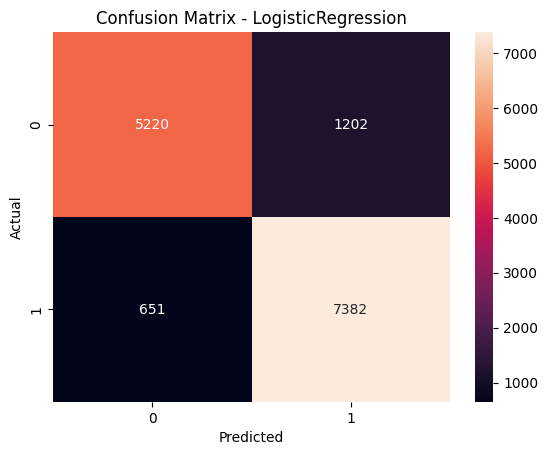

In [22]:
evaluate_model(lr_model, X_test, y_test)

In [23]:
# Save the model to a file using joblib
joblib.dump(lr_model, '../models/logistic_regression_classifier.pkl')

['../models/logistic_regression_classifier.pkl']

### Evaluate Gradient Boosting Classifier

Evaluating GradientBoostingClassifier...
GradientBoostingClassifier Results:
Accuracy: 93.8%
Recall: 93.4%
Precision: 95.3%
F1 Score: 94.4%

Classification Report:
              precision    recall  f1-score   support

           0      0.920     0.943     0.931      6422
           1      0.953     0.934     0.944      8033

    accuracy                          0.938     14455
   macro avg      0.937     0.939     0.937     14455
weighted avg      0.938     0.938     0.938     14455



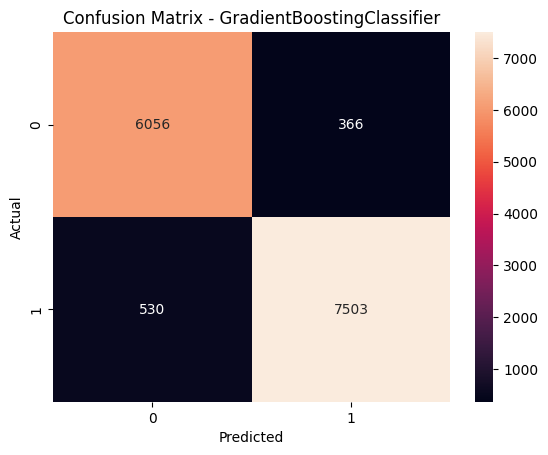

In [24]:
evaluate_model(model_GB, X_test, y_test)

In [25]:
# Save the model to a file using joblib
joblib.dump(model_GB, '../models/gradient_boosting_classifier.pkl')

['../models/gradient_boosting_classifier.pkl']

## ROC and Precision-Recall curves

In [26]:
# Evaluate the model on the test set
y_pred = model_GB.predict(X_test) 
y_pred_prob = model_GB.predict_proba(X_test)[:, 1]

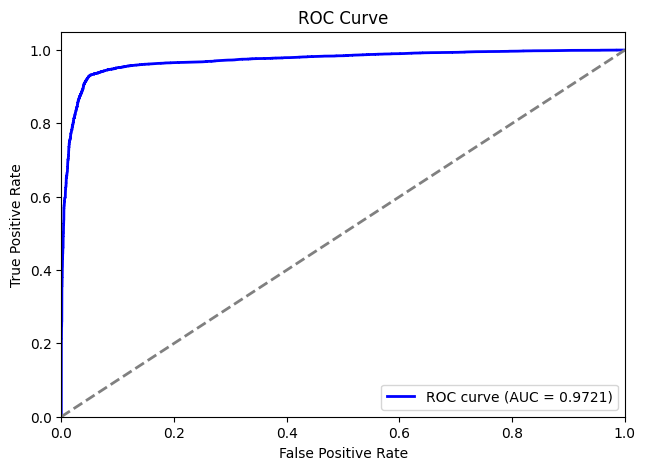

In [27]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure(figsize=(16, 5))

# Subplot: ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

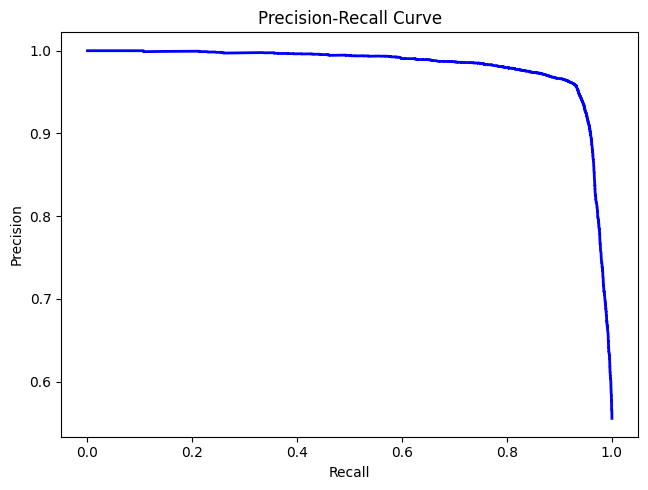

In [28]:
plt.figure(figsize=(12.5, 5))
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

plt.tight_layout()
plt.show()


# Deep Learning model - Dense Neural Net

In [29]:
features_num = X_train.shape[1]

In [30]:
NN_model = Sequential([
    Input(shape=(features_num,)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
NN_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [31]:
# Training the Model

print("Training the model...")
history = NN_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Training the model...
Epoch 1/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8011 - loss: 0.4579 - val_accuracy: 0.8902 - val_loss: 0.2984
Epoch 2/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8866 - loss: 0.3241 - val_accuracy: 0.8987 - val_loss: 0.2802
Epoch 3/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8965 - loss: 0.3011 - val_accuracy: 0.9064 - val_loss: 0.2682
Epoch 4/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9038 - loss: 0.2884 - val_accuracy: 0.9102 - val_loss: 0.2613
Epoch 5/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9096 - loss: 0.2810 - val_accuracy: 0.9092 - val_loss: 0.2571
Epoch 6/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9106 - loss: 0.2759 - val_accuracy: 0.9122 - val_loss: 0.2522
Epoch 7/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9129 - loss: 0.2676 - val_accuracy: 0.9130 - val_loss: 0.2488
Epoch 8/50
723/723 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9163 - loss: 0.2

In [32]:
test_loss, test_acc = NN_model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy NN:', test_acc)

452/452 - 0s - 705us/step - accuracy: 0.9260 - loss: 0.2257

Test accuracy NN: 0.9260463714599609


In [33]:
# Evaluating the Model

print("Evaluating the model...")
y_pred_train = NN_model.predict(X_train)
y_pred_test = NN_model.predict(X_test)

# Convert probabilities to binary predictions
y_pred_train = (y_pred_train > 0.5).astype(int)
y_pred_test = (y_pred_test > 0.5).astype(int)

def evaluate_model(y_true, y_pred, dataset_type="Test"):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"{dataset_type} Set Evaluation:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {dataset_type} Set')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Evaluating the model...
1807/1807 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step


Training Set Evaluation:
Accuracy: 0.93
Recall: 0.93
Precision: 0.93
F1 Score: 0.93


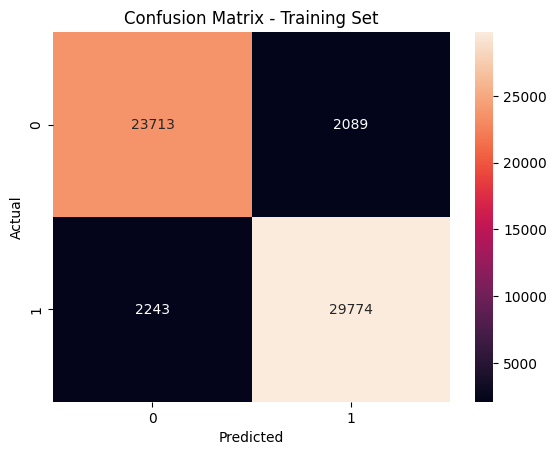

Test Set Evaluation:
Accuracy: 0.93
Recall: 0.93
Precision: 0.94
F1 Score: 0.93


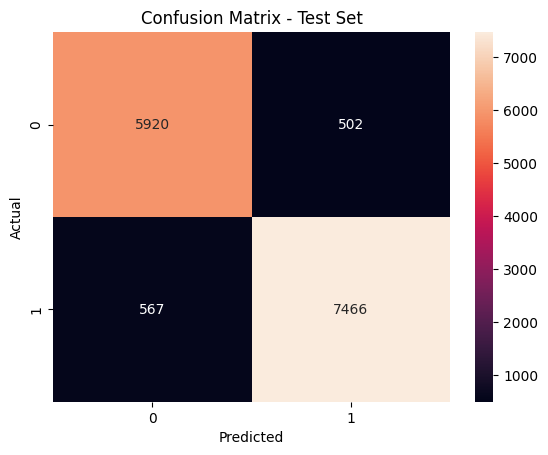

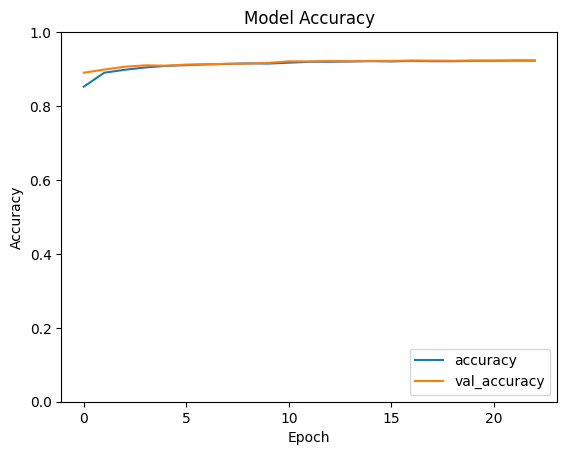

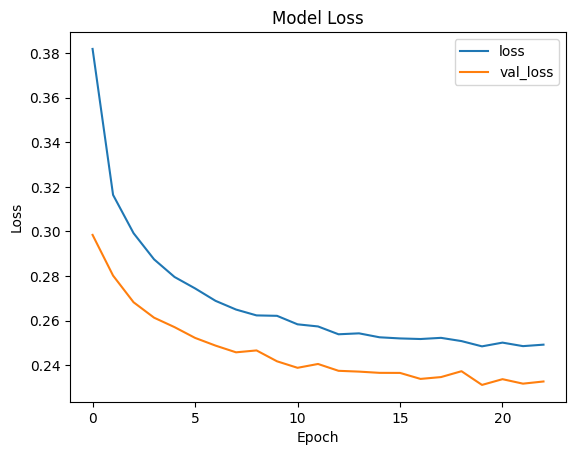

In [34]:
# Evaluate on training set
evaluate_model(y_train, y_pred_train, "Training")

# Evaluate on test set
evaluate_model(y_test, y_pred_test)

# Plotting Training History

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

In [35]:
# save model 
NN_model.save('../models/dense_neural_net_classifier.keras')